In [1]:
import genjax
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
from genjax import grasp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import rcParams
from scipy.interpolate import griddata

console = genjax.pretty()
key = jax.random.PRNGKey(314159)
sns.set_theme(style="white")
font_path = (
    "/home/femtomc/.local/share/fonts/Unknown Vendor/TrueType/Lato/Lato_Bold.ttf"
)
font_manager.fontManager.addfont(font_path)
custom_font_name = font_manager.FontProperties(fname=font_path).get_name()
rcParams["font.family"] = custom_font_name

console = genjax.pretty()
key = jax.random.PRNGKey(314159)

In [2]:
@genjax.gen
def model():
    x = grasp.normal_reparam(0.0, 10.0) @ "x"
    y = grasp.normal_reparam(0.0, 10.0) @ "y"
    rs = x**2 + y**2
    z = grasp.normal_reparam(rs, 0.1 + (rs / 100.0)) @ "z"

In [3]:
# A more expressive variational family.
@genjax.gen
def expressive_variational_family(ϕ, data):
    z = data["z"]
    u = grasp.uniform() @ "u"
    θ = 2 * jnp.pi * u
    log_σ1, log_σ2 = ϕ
    x = grasp.normal_reparam(jnp.sqrt(z) * jnp.cos(θ), jnp.exp(log_σ1)) @ "x"
    y = grasp.normal_reparam(jnp.sqrt(z) * jnp.sin(θ), jnp.exp(log_σ2)) @ "y"


marginal_q = grasp.marginal(
    genjax.select("x", "y"), expressive_variational_family, lambda: grasp.sir(20)
)

data = genjax.choice_map({"z": 5.0})
hvi_objective = grasp.elbo(model, marginal_q, data)

In [4]:
# Training with IWAE.
key = jax.random.PRNGKey(314159)
ϕ = (0.0, 0.0)
jitted = jax.jit(jax.vmap(hvi_objective.value_and_grad_estimate, in_axes=(0, None)))
for i in range(0, 20000):
    key, sub_key = jax.random.split(key)
    sub_keys = jax.random.split(sub_key, 64)
    loss, (_, ((ϕ_grads, _), ())) = jitted(sub_keys, ((), ((ϕ, data), ())))
    ϕ = jtu.tree_map(lambda v, g: v + 1e-3 * jnp.mean(g), ϕ, ϕ_grads)
    if i % 1000 == 0:
        print(jnp.mean(loss))
print(ϕ)

-324.31888
-6.8666677
-6.89077
-6.905264
-6.6629252
-6.843478
-6.847993
-6.9238586
-6.708169
-7.086153
-6.921113
-7.00263
-6.815769
-6.8413544
-6.828184
-6.943825
-6.948656
-6.9690757
-6.969285
-7.0648775
(Array(-3.0945423, dtype=float32), Array(-3.086999, dtype=float32))


## Sampling from the prior variational family

In [5]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 100000)
data = genjax.choice_map({"z": 5.0})
ϕ_prior = (-0.3, -0.3)
scores, v_chm = jax.jit(jax.vmap(marginal_q.random_weighted, in_axes=(0, None, None)))(
    sub_keys, (ϕ_prior, data), ()
)

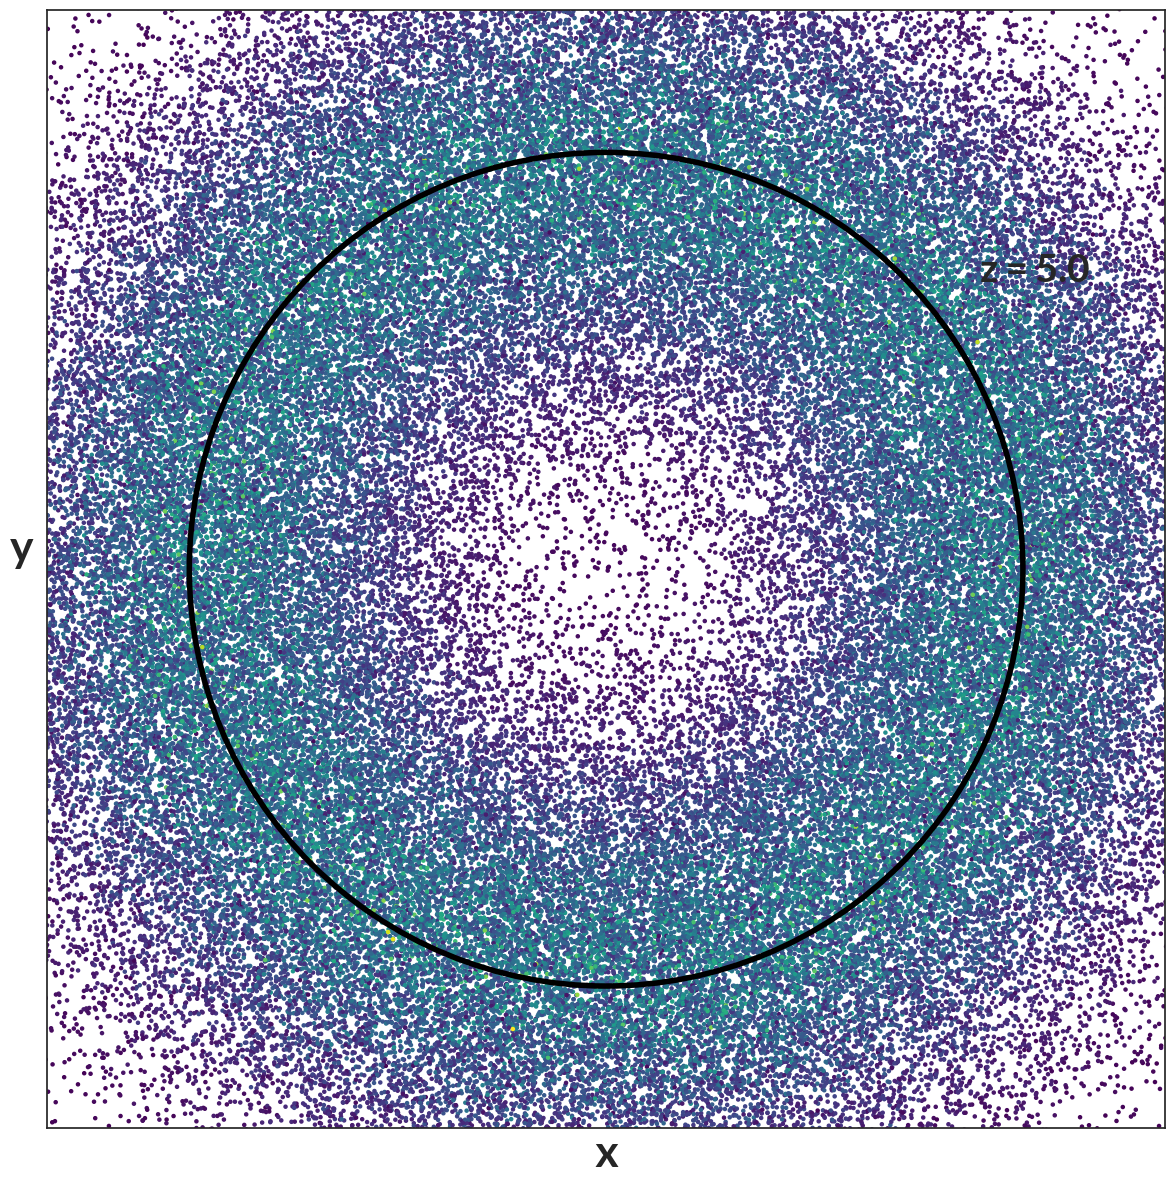

In [6]:
chm = v_chm.get_leaf_value()
x, y = chm["x"], chm["y"]
scores = jnp.exp(scores)

fig, ax = plt.subplots(figsize=(12, 12))
label_fontsize = 32  # Set the desired font size here

# Define the circle
circle = patches.Circle((0.0, 0.0), radius=jnp.sqrt(5.0), fc="none", ec="black", lw=4)

# Set aspect ratio to equal to ensure the circle isn't elliptical
ax.set_aspect("equal")

ax.scatter(x, y, c=scores, cmap="viridis", marker=".", s=20)
# Add the circle to the plot
ax.add_patch(circle)
ax.text(2.3, 1.6, "z = 5.0", ha="center", va="center", fontsize=28)

# Set the limits of the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("x", fontsize=label_fontsize)
ax.set_ylabel("y", fontsize=label_fontsize)
ax.set_xticks([])
ax.set_yticks([])
ax.yaxis.labelpad = 18  # adjust the value as needed
ax.yaxis.label.set_rotation(0)  # 90 degrees for vertical

plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area

fig.savefig("img/untrained_expressive_variational_elbo_samples.svg", format="svg")

# Show the plot
plt.show()

## Sampling from trained variational family

In [7]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 100000)
data = genjax.choice_map({"z": 5.0})
scores, v_chm = jax.jit(jax.vmap(marginal_q.random_weighted, in_axes=(0, None, None)))(
    sub_keys, (ϕ, data), ()
)

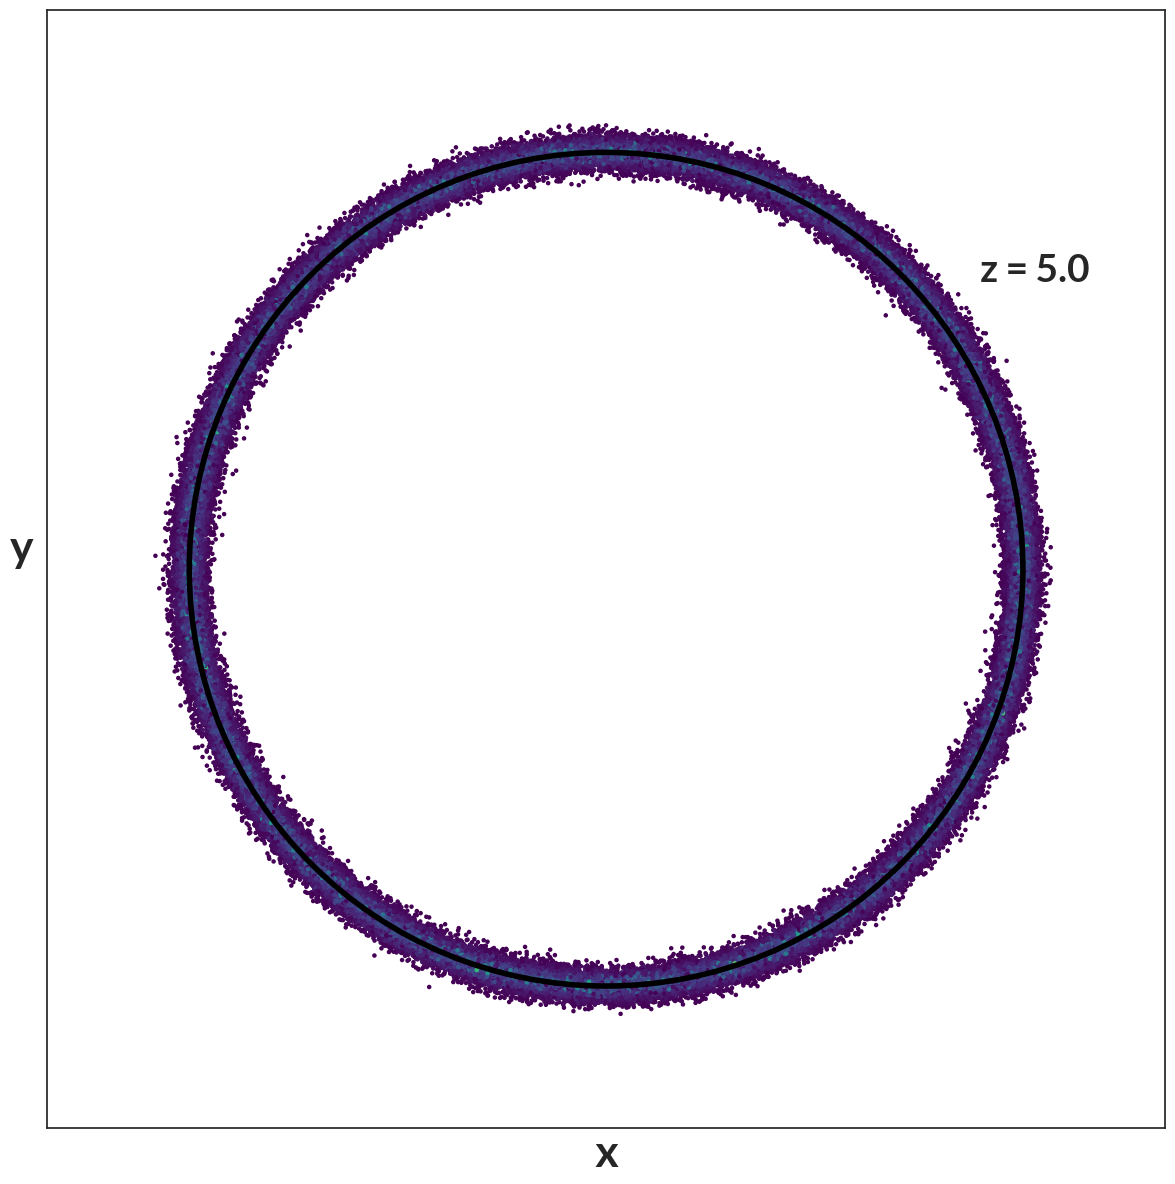

In [8]:
chm = v_chm.get_leaf_value()
x, y = chm["x"], chm["y"]
scores = jnp.exp(scores)

fig, ax = plt.subplots(figsize=(12, 12))
label_fontsize = 32  # Set the desired font size here

# Set aspect ratio to equal to ensure the circle isn't elliptical
ax.set_aspect("equal")

ax.scatter(x, y, c=scores, cmap="viridis", marker=".", s=20)

# Define the circle
circle = patches.Circle((0.0, 0.0), radius=jnp.sqrt(5.0), fc="none", ec="black", lw=4)

# Add the circle to the plot
ax.add_patch(circle)
ax.text(2.3, 1.6, "z = 5.0", ha="center", va="center", fontsize=28)

# Set the limits of the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("x", fontsize=label_fontsize)
ax.set_ylabel("y", fontsize=label_fontsize)
ax.set_xticks([])
ax.set_yticks([])
ax.yaxis.labelpad = 18  # adjust the value as needed
ax.yaxis.label.set_rotation(0)  # 90 degrees for vertical

plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area

fig.savefig("img/trained_expressive_variational_elbo_samples.svg", format="svg")

# Show the plot
plt.show()